In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

    
    
    
def Belief(State,p,r):
   
    equilibrium = r/(1-p+r);
    
    if State[0]== 0 and State[1]> 0:
            Belief = (r-r*(p-r)**(State[1]))/(1+r-p);
    elif State[0]== 1 and State[1]> 0:
            Belief = (r+(1-p)*(p-r)**(State[1]))/(1+r-p);
            
    else:
        
        Belief = equilibrium;

    return Belief;
            
        
def WhittleIndex(State,p,r):
    WhittleIndex = 0.;

    
    if State[0]== 0 and State[1]>0:
        l= State[1];
        x= Belief([0,l],p,r);
        y=Belief([0,l+1],p,r);
        WhittleIndex =((x-y)*(l+1)+y)/(1-p+(x-y)*l+y); 
    elif State[0] == 1:
        WhittleIndex = r/((1-p)*(1+r-p)+r);
    
    else:
        WhittleIndex = r/((1-p)*(1+r-p)+r);
            
    return WhittleIndex;

def update(S,C,Reward,alpha,p,r,q,s,gamma,N):
        #the update process of each timestep.
        
        #S is the list of belief states of all channels.
        #C is the list of actual channel states.
        W = [0.]*N;
        Y = [0.]*N;
        Action = [0]*N;
        Threshold = 0.;
        Seed = np.random.rand(N);
        
       #Get the Threshold. 
        for i in range(int(N*gamma)):
            Y[i]= WhittleIndex(S[i],p,r);
        for i in range(int(N*gamma),N):
            Y[i]= WhittleIndex(S[i],q,s);
        
        Y.sort();
        Threshold = Y[int((1-alpha)*N)];
        
        
        
       #Get the Action vector.
        for i in range(int(N*gamma)):
            W[i]= WhittleIndex(S[i],p,r);
        for i in range(int(N*gamma),N):
            W[i]= WhittleIndex(S[i],q,s);
    
        h=0;
        for i in range(N):
            if W[i]>= Threshold:
                Action[i]=1;
                h=h+1;
            if h >= alpha*N:
                break;
            
       #The update process.
       
        for i in range(int(N*gamma)):
        
            if Action[i] == 0 and S[i][1]>0:
                S[i][1]= S[i][1]+1;
                if C[i]==0:
                    if Seed[i]<r:
                        C[i]=1;
                    else:
                        C[i]=0;
                else:
                    if Seed[i]<p:
                        C[i]=1;
                    else:
                        C[i]=0;
                
                
                
               
             
            elif Action[i] == 0 and S[i][1]==0:
                if C[i]==0:
                    if Seed[i]<r:
                        C[i]=1;
                    else:
                        C[i]=0;
                else: 
                    if Seed[i]<p:
                        C[i]=1;
                    else:
                        C[i]=0;
            
            else:
                if C[i]==1:
                    S[i]= [1,1];
                    Reward = Reward + 1;
                    C[i]= int((Seed[i]<p)==True);
                    
                else:
                    S[i]= [0,1];
                    C[i]= int((Seed[i]<r)==True);
        
        for i in range(int(N*gamma),N):
        
            if Action[i] == 0 and S[i][1]>0:
                S[i][1]= S[i][1]+1;
                if C[i]==0:
                    if Seed[i]<s:
                        C[i]=1;
                    else:
                        C[i]=0;
                else:
                    if Seed[i]<q:
                        C[i]=1;
                    else:
                        C[i]=0;
                
                
                
               
             
            elif Action[i] == 0 and S[i][1]==0:
                if C[i]==0:
                    if Seed[i]<s:
                        C[i]=1;
                    else:
                        C[i]=0;
                else: 
                    if Seed[i]<q:
                        C[i]=1;
                    else:
                        C[i]=0;
            
            else:
                if C[i]==1:
                    S[i]= [1,1];
                    Reward = Reward + 1;
                    C[i]= int((Seed[i]<q)==True);
                    
                else:
                    S[i]= [0,1];
                    C[i]= int((Seed[i]<s)==True);
        
        
        
        return Reward;
    

In [2]:
def onetrial(S,C,Reward,timesteps,alpha,p,r,q,s,gamma,N):

    for i in range(timesteps):
        Reward = update(S,C,Reward,alpha,p,r,q,s,gamma,N);
    return Reward;

In [3]:
import numpy as np

class Parameters:
    
    def __init__(self,timesteps,alpha,p,r,q,s,gamma,N):
        self.timesteps = timesteps;
        self.alpha = alpha;
        self.p = p
        self.r = r
        self.q = q
        self.s = s
        self.gamma = gamma
        self.N = N
    
    def fileName(self):
        
        return 'output/CI_Demo_{}_{}_{}_{}_{}_{}_{}_{}.npy'.format(self.timesteps,self.alpha,self.p,self.r,self.q,self.s,self.gamma,self.N)
    
def simulate(parameters):
    
    return onetrial([[0,0]]*parameters.N,[0]*parameters.N,0,parameters.timesteps,parameters.alpha,parameters.p,parameters.r,parameters.q,parameters.s,parameters.gamma,parameters.N);


def computeAndSave(parameters,number_of_replicas_to_compute):
    
    fileName = parameters.fileName();
    sum_of_results = 0;
    sum_of_squares = 0;
    number_computed = 0;
    
    try:
        print('file',fileName,'exists')
        sum_of_results,sum_of_squares,number_computed = np.load(fileName,allow_pickle = True)
        
    except Exception as e:
        print(e);
        
    if number_computed < number_of_replicas_to_compute:
        print('We should do more computations');
        for n in range(number_computed,number_of_replicas_to_compute):
            result = simulate(parameters)
            sum_of_results += result
            sum_of_squares += result**2
            
        np.save(fileName,np.array([sum_of_results,sum_of_squares,number_of_replicas_to_compute]))
        
        number_computed = number_of_replicas_to_compute;
        
    print('all computation done for',parameters.fileName())
        
    average = 100*sum_of_results / (number_computed*parameters.N*parameters.timesteps)
    confidence = 100*(np.sqrt((sum_of_squares / number_computed-average**2)/number_computed))/(parameters.N*parameters.timesteps)
        
    return average,confidence
    
    

    

file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_5.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_15.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_25.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_45.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_35.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_125.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_105.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_75.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_145.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_95.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_65.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_85.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_115.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_155.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_135.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_5

file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_355.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_290.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_340.npy exists
all computation done for output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_280.npy
all computation done for output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_310.npy
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_345.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_320.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_240.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_365.npy exists
all computation done for output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_250.npy
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_375.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_330.npy exists
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_395.npy exists
all computation done for output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_355.npy
file output/CI_Demo_500_0.3_0.75_0.2_0.8_0.3_0.6_385

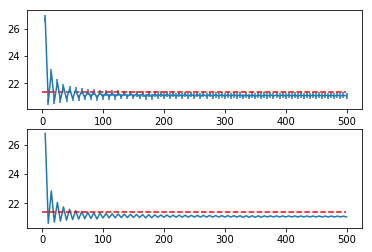

In [19]:
from multiprocessing import Pool

A = [0]*100;
C = [0]*100;

def worker(n):
    return computeAndSave(Parameters(500,0.3,0.75,0.2,0.8,0.3,0.6,n),10000)

num_processors = 16;
p=Pool(processes = num_processors);

t = list(range(5,505,5));

X = p.map(worker,t)

for i in range(100):
    A[i] = X[i][0]
    C[i] = X[i][1]
    


t = list(range(5,505,5))
s = np.arange(0.,500.,0.5)

plt.subplot(2,1,1)
plt.errorbar(t,A,C)
plt.plot(s,[21.387]*1000,'r--')



plt.subplot(2,1,2)
plt.plot(t,A,s,[21.387]*1000,'r--')



#21.387    

In [20]:
from multiprocessing import Pool

A = [0]*100;
C = [0]*100;

def worker(n):
    return computeAndSave(Parameters(500,0.5,0.9,1/15,0.5,1/3,0.6,n),10000)

num_processors = 16;
p=Pool(processes = num_processors);

t = list(range(5,505,5));

X = p.map(worker,t)

for i in range(100):
    A[i] = X[i][0]
    C[i] = X[i][1]
    
t = list(range(5,505,5))
s = np.arange(0.,500.,0.5)

plt.subplot(2,1,1)
plt.errorbar(t,A,C)
plt.plot(s,[29.298]*1000,'r--')



plt.subplot(2,1,2)
plt.plot(t,A,s,[29.298]*1000,'r--')


#29.298

file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_5.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_65.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_25.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_115.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_45.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_55.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_85.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_35.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_75.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_15.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.333333333333

all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_245.npy
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_170.npy exists
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_235.npy
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_225.npy
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_305.npy exists
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_285.npy
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_220.npy exists
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_255.npy
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_295.npy
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0

file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_410.npy exists
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_360.npy exists
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_455.npy
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_420.npy
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_400.npy exists
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_450.npy
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_340.npy
file output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_475.npy exists
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.3333333333333333_0.6_320.npy
all computation done for output/CI_Demo_500_0.5_0.9_0.06666666666666667_0.5_0.33333333333